<a href="https://colab.research.google.com/github/DanielHevdeli/Practical-Computational-Power-of-RNNs/blob/main/rnn_paper_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Author**: Daniel Hevdeli.

This project is based on the paper [On the Practical Computational Power of Finite Precision RNNs](https://arxiv.org/pdf/1805.04908) by Gail Weiss, Yoav Goldberg and Eran Yahav. Its about showing that although they are theoretically equivalent, practically, different RNN architechtures have different computational power. As mentioned in the paper, while RNNs are famously known to be Turing
complete, this relies on infinite precision in the states and unbounded computation time. I will consider the case of RNNs with finite precision whose computation time is linear in the input length (like typical RNNs for NLP tasks, available by the various deep learning frameworks, trained by the backpropagation algorithm). Under these limitations, I will show that different RNNs have different computational power. In particular, I will show that the Long Short Term Memory (LSTM) architechture is strictly stronger than the Gated Recurrent Unit (GRU). This is achieved by showing that LSTM can easily implement counting behavior, in contrast to the GRU.

# Intuition

In order to show that LSTM and GRU have different computational power, the authors chose to explore about counting. But why?

The answer is hidden in the differential gates using by both architechture. Lets take a look in both arcitechtures. they both maintain a state for each time step $t$, called $h_t\:$, defined by a reccurent function: $\:h_t = RNN(h_{t-1}, x_t)$ where $h_{t-1}$ is the state from the last time step, and $x_t$ is the new input in the current time step. But, the (learnable) recurrent function is different.

**GRU:** the GRU uses 2 gates, $r, z\:$ each of the form $σ(W ⋅ x_t + b + W'⋅ h_{t-1} + b'\:)$ where $\:W,W',b,b'$ are learnable parameters, different for each gate, and $σ$ is the sigmoid function.
the formula for updating $h$ is $h_t = (1-z_t)⋅n_t + z_t⋅h_{t-1}\:$ where $\:n_t$ is the proposal for the new state and is given by the following formula: $n_t = tanh(W ⋅ x_t + b + r_t ⋅(W'⋅ h_{t-1} + b'))$ where $\:W,W',b,b'$ are another different learnable parameters.

**LSTM:** the LSTM uses 3 gates, $i, f, o$ (stands for input, forget and output gates), all of the same form as the GRU's gates. Unlike GRU, LSTM maintains a cell state $c$ from which he expose $h\:$ by $h_t = o_t ⋅ tanh(c_t)$. The formula for updating $c_t$ is $c_t = f_t ⋅ c_{t-1} + i_t ⋅ g_t$ where $g_t\:$ is the proposal for the new cell state and is defined as $g_t = tanh(W ⋅ x_t + b + W'⋅ h_{t-1} + b')$ ($\:W,W',b,b'$ are another different learnable parameters)

Now, cells in a vector can be considered as counters if at each step of
the computation each cell can be incremented, decremented, or ignored. LSTM can easily maintain such a mechanism. In non-counting steps, set $i_t = 0, f_t = 1\:$ (by fully saturate the gates with very high or very low values. (e.g., $σ(10) ≈ 1, σ(-10) ≈ -1$). In counting steps, the counter direction ($+1$ or $-1$) is set in $g_t$ based on the input $x_t$ and the state $h_{t−1}$ (again, by fully saturate the $tanh$ with very high or very low values. e.g., $tanh(10) ≈ 1, tanh(-10) ≈ -1$), and the counting itself is performed by setting $f_t = i_t = 1\:$.
But, Finite-precision GRUs cannot implement unbounded counting on a given dimension. the $tanh$ combined with the inverse gates ($z_t, 1-z_t$) restrict the values in $h$ to always be in $(-1,1)$, what prevents unbounded counting with finite precision. Practically, as I will show, the GRU can learn to count up to some bound $N$ seen in training, but will not generalize well beyond that. Moreover, simulating forms of counting behavior within the range $(-1,1)$ requires consistently setting $z,r,n,h$ to precise, non-saturated values, making it much harder to find and maintain stable solutions.

# Import of Relevant Libraries

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
save_path = '/content/drive/My Drive/RNN_paper_project'
data_dir = 'Data'
models_dir = 'Models'
# %cd $save_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generating Training Data


We will define 2 formal languages:

$L_1 = \{a^nb^n \:|\: n ∈ [1,N]\}$

$L_2 = \{a^nb^nc^n \:|\: n ∈ [1,N]\}$

Positive samples are generated by sampling elements from $L_1, L_2$. Negative samples for $L_1$ are generated by sampling $2$ different values in the range $[1,N]$. Negative samples for  $L_2$  are generated by sampling $3$ values in the range $[1,N]$ ensuring at least two are different.

In [ ]:
l1_N = 100
l2_N = 50
l1_n_samples = 1000
l2_n_samples = 1000

In [ ]:
def generate_l1_samples(n_samples: int, N: int):
  """
  Generates n_samples of pos samples, and n_samples of neg samples of L1 lang.
  """
  pos_samples = []
  neg_samples = []
  for i in range(n_samples):
    # generate pos sample
    n = random.randint(1, N)
    pos_sample = 'a' * n + 'b' * n
    pos_samples.append((pos_sample, (n, n)))

    # generate neg sample
    n1 = random.randint(1, N)
    n2 = random.randint(1, N)
    while n1 == n2:
      n2 = random.randint(1, N)
    neg_sample = 'a' * n1 + 'b' * n2
    neg_samples.append((neg_sample, (n1, n2)))

  return pos_samples, neg_samples

In [ ]:
def generate_l2_samples(n_samples: int, N: int):
  """
  Generates n_samples of pos samples, and n_samples of neg samples of L2 lang.
  """
  pos_samples = []
  neg_samples = []
  for i in range(n_samples):
    # generate pos sample
    n = random.randint(1, N)
    pos_sample = 'a' * n + 'b' * n + 'c' * n
    pos_samples.append((pos_sample, (n, n, n)))

    # generate neg sample
    n1 = n2 = n3 = 0
    while n1 == n2 and n2 == n3:
      n1 = random.randint(1, N)
      n2 = random.randint(1, N)
      n3 = random.randint(1, N)
    neg_sample = 'a' * n1 + 'b' * n2 + 'c' * n3
    neg_samples.append((neg_sample, (n1, n2, n3)))

  return pos_samples, neg_samples

In [ ]:
l1_csv_path = os.path.join(save_path, data_dir, 'trainL1.csv')
l2_csv_path = os.path.join(save_path, data_dir, 'trainL2.csv')

if os.path.exists(l1_csv_path) and os.path.exists(l2_csv_path):
    print("CSV files exist. Reading data from CSV...")
    l1_df = pd.read_csv(l1_csv_path, usecols=['elem', 'label'])
    l2_df = pd.read_csv(l2_csv_path, usecols=['elem', 'label'])
else:
    print("CSV files do not exist. Generating data...")
    l1_pos_samples, l1_neg_samples = generate_l1_samples(n_samples=l1_n_samples, N=l1_N)
    l2_pos_samples, l2_neg_samples = generate_l2_samples(n_samples=l2_n_samples, N=l2_N)

    l1_df = pd.DataFrame(l1_pos_samples + l1_neg_samples, columns=['elem', 'ns'])
    l1_df['label'] = [1] * len(l1_pos_samples) + [0] * len(l1_neg_samples)

    l2_df = pd.DataFrame(l2_pos_samples + l2_neg_samples, columns=['elem', 'ns'])
    l2_df['label'] = [1] * len(l2_pos_samples) + [0] * len(l2_neg_samples)

    l1_df.to_csv(l1_csv_path, index=False)
    l2_df.to_csv(l2_csv_path, index=False)
    print("Data generated and saved to CSV files.")
    l1_df = l1_df[['elem', 'label']]
    l2_df = l2_df[['elem', 'label']]
    # print(l1_df.head())
    # print(l2_df.head())


CSV files do not exist. Generating data...
Data generated and saved to CSV files.


# Create Dataset, Split into Train, Validation

In [ ]:
class CharIndex():
    def __init__(self):
        self.char_2_idx = {'a': 0, 'b': 1, 'c': 2}
        self.idx_to_char = {0: 'a', 1: 'b', 2: 'c'}

    def sample_indices(self, sample):
        return [self.char_2_idx[char] for char in sample]

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df: pd.DataFrame, charIdx: CharIndex):
        self.df = df
        self.charIdx = charIdx

    def __getitem__(self, index):
        sample = self.df.elem.iloc[index]
        label = self.df.label.iloc[index]

        item_tensor = torch.tensor(self.charIdx.sample_indices(sample))
        label_tensor = torch.tensor(label)

        return item_tensor, label_tensor

    def __len__(self):
        return len(self.df)

def collate_fn(batch):
    samples, labels = zip(*batch)
    lengths = [len(sample) for sample in samples]
    samples = nn.utils.rnn.pad_sequence(samples, batch_first=True)
    return samples, torch.tensor(labels), lengths


We will split data to $80\%$ train and $20\%$ validation.

In [ ]:
l1_train_df, l1_val_df = train_test_split(l1_df, test_size=0.2, shuffle=True)
l1_train_set = Dataset(l1_train_df, CharIndex())
l1_val_set = Dataset(l1_val_df, CharIndex())

l2_train_df, l2_val_df = train_test_split(l2_df, test_size=0.2, shuffle=True)
l2_train_set = Dataset(l2_train_df, CharIndex())
l2_val_set = Dataset(l2_val_df, CharIndex())

In [ ]:
vocab_size = 3
n_labels = 2
batch_size = 32

In [ ]:
l1_train_loader = torch.utils.data.DataLoader(l1_train_set, batch_size,
                                          shuffle=True, collate_fn=collate_fn)
l1_val_loader = torch.utils.data.DataLoader(l1_val_set, batch_size,
                                          shuffle=True, collate_fn=collate_fn)

l2_train_loader = torch.utils.data.DataLoader(l2_train_set, batch_size,
                                          shuffle=True, collate_fn=collate_fn)
l2_val_loader = torch.utils.data.DataLoader(l2_val_set, batch_size,
                                          shuffle=True, collate_fn=collate_fn)

# Models Architechtures

We will create $2$ different RNN architechtures using Pytorch.

In [ ]:
class TemplateRNN(nn.Module):
    def __init__(self, rnnType: str,
                 vocab_size: int = 3,
                 embb_dim: int = 3,
                 hidden_state_size: int = 10,
                 n_classes: int = 2):

        super(TemplateRNN, self).__init__()
        self.rnnType = rnnType
        self.vocab_size = vocab_size
        self.embb_dim = embb_dim
        self.hidden_state_size = hidden_state_size
        self.n_classes = n_classes

        # Embedding layer
        # self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embb_dim)
        # using fixed one-hot encoding.
        self.embedding_matrix = torch.eye(vocab_size)
        self.embedding = nn.Embedding(vocab_size, vocab_size)
        self.embedding.weight = nn.Parameter(self.embedding_matrix, requires_grad=False)

        # RNN layer
        if self.rnnType == 'GRU':
          self.rnn = nn.GRU(input_size=embb_dim,
                          hidden_size=hidden_state_size,
                          batch_first=True)
        elif self.rnnType == 'LSTM':
          self.rnn = nn.LSTM(input_size=embb_dim,
                          hidden_size=hidden_state_size,
                          batch_first=True)
        else: # Elman RNN
          self.rnn = nn.RNN(input_size=embb_dim,
                          hidden_size=hidden_state_size,
                          batch_first=True)
        # Linear layer
        self.fc = nn.Linear(in_features=hidden_state_size, out_features=n_classes)




    def forward(self, x, lengths):
      """
      input:
      x: (batch_size, seq_len)
      lengths: (batch_size)
      return:
      y: (batch_size, n_classes) - logits of the model.
      unpacked_out: (batch_size, seq_len, hidden_size) - hidden states of the RNN for each time step.
      unpacked_lens: (batch_size) - lengths of the sequences in the batch.
      """

      # print("padded x: ", x)
      # print("lengths: ", lengths)   # x: (batch_size, seq_len)
      # print('-' * 100)
      x = self.embedding(x)   # x: (batch_size, seq_len, embb_dim)
      # print("x embeddings: ", x.shape)
      packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True,
                                                   enforce_sorted=False)
      out, _  = self.rnn(packed_x)
      unpacked_out, unpacked_lens = nn.utils.rnn.pad_packed_sequence(out, batch_first=True) #  inverse operation to pack_padded_sequence()
      # print("unpacked_out: ", unpacked_out.shape)   # unpacked_out: (batch_size, seq_len, hidden_size)
      # print("unpacked_out: ", unpacked_out)
      # print("unpacked_lens: ", unpacked_lens)
      # print('-' * 100)
      last_hidden_states = []
      for i, length in enumerate(unpacked_lens):
        last_hidden_states.append(unpacked_out[i, length - 1, :])

      h_n = torch.stack(last_hidden_states)  # Stack hidden states into a tensor

      # self.rnn.register_forward_hook()

      # Wrong: h_n = unpacked_out[:, -1, :]
      # print("h_n: ", h_n.shape)   # h_n: (batch_size, hidden_size)
      # print('-' * 100)
      y = self.fc(h_n)
      # print("y: ", y.shape)   # y: (batch_size, n_classes)
      # print('-' * 100)
      return y, unpacked_out, unpacked_lens

    def get_lstm_cell_states(self, x):
      x = self.embedding(x)   # x: (1, seq_len, embb_dim)
      x = x.squeeze(0)        # x: (seq_len, embb_dim)
      seq_len, embb_dim = x.shape
      all_cell_states = []
      all_hidden_states = []
      h = torch.zeros(1, self.hidden_state_size)
      c = torch.zeros(1, self.hidden_state_size)
      for t in range(seq_len):
        _, (h, c) = self.rnn(x[t].unsqueeze(0), (h, c))
        all_cell_states.append(c.squeeze(0))
        all_hidden_states.append(h.squeeze(0))

      all_cell_states = torch.stack(all_cell_states)
      all_hidden_states = torch.stack(all_hidden_states)

      # print("all_cell_states: ", all_cell_states.shape)
      # print("all_hidden_states: ", all_hidden_states.shape)

      return all_cell_states, all_hidden_states



# Training

In [ ]:
epochs = 100
lr = 0.005
criterion = nn.CrossEntropyLoss()

In [ ]:
def compute_accuracy(model: TemplateRNN, criterion, loader: torch.utils.data.DataLoader):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        for samples, labels, lengths in loader:
            # print("samples: ", samples.shape)
            # print("labels: ", labels.shape)
            outputs, _, _ = model(samples, lengths)
            # print("model outputs:", outputs.shape)
            l = criterion(outputs, labels)
            loss += l.item()
            outputs = torch.softmax(outputs, dim=1)
            # print("softmax: ", outputs.shape)
            probabilities, predicted_labels = torch.max(outputs, dim=1)
            # print("probabilities: ", probabilities.shape)
            # print("predicted_labels: ", predicted_labels.shape)
            correct += (predicted_labels == labels).sum().item()
            total += len(labels)
    avg_loss = loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [ ]:
def train_model(model: TemplateRNN, epochs, criterion, optimizer, train_loader, val_loader):

    for epoch in range(epochs):

        train_loss = 0.0
        model.train()
        for samples, labels, lengths in tqdm(train_loader):
            model.zero_grad()
            outputs, _, _ = model(samples, lengths)
            l = criterion(outputs, labels)
            l.backward()
            optimizer.step()
            train_loss += l.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss, accuracy = compute_accuracy(model, criterion, loader=val_loader)
        print(f'Epoch {epoch+1}/{epochs}: \
                train loss: {avg_train_loss:.4f} \
                validation loss: {avg_val_loss:.4f} \
                validation accuracy: {accuracy}%')

        if accuracy >= 98.0:
          break


In [ ]:
l1_gru_model = TemplateRNN(rnnType='GRU',
                    vocab_size=vocab_size,
                    embb_dim=vocab_size,
                    n_classes=n_labels)

train_model(model=l1_gru_model,
            epochs=epochs,
            criterion=criterion,
            optimizer=optim.Adam(l1_gru_model.parameters(), lr=lr),
            train_loader=l1_train_loader,
            val_loader=l1_val_loader)


100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


Epoch 1/100:                 train loss: 0.6966                 validation loss: 0.6953                 validation accuracy: 49.25%


100%|██████████| 50/50 [00:05<00:00,  9.63it/s]


Epoch 2/100:                 train loss: 0.6931                 validation loss: 0.6913                 validation accuracy: 51.75%


100%|██████████| 50/50 [00:07<00:00,  6.79it/s]


Epoch 3/100:                 train loss: 0.6876                 validation loss: 0.6804                 validation accuracy: 47.25%


100%|██████████| 50/50 [00:06<00:00,  7.78it/s]


Epoch 4/100:                 train loss: 0.6661                 validation loss: 0.6639                 validation accuracy: 42.75%


100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


Epoch 5/100:                 train loss: 0.6144                 validation loss: 0.5592                 validation accuracy: 67.5%


100%|██████████| 50/50 [00:06<00:00,  7.40it/s]


Epoch 6/100:                 train loss: 0.5140                 validation loss: 0.4144                 validation accuracy: 89.25%


100%|██████████| 50/50 [00:07<00:00,  7.14it/s]


Epoch 7/100:                 train loss: 0.3593                 validation loss: 0.2258                 validation accuracy: 93.5%


100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


Epoch 8/100:                 train loss: 0.5699                 validation loss: 0.5110                 validation accuracy: 75.0%


100%|██████████| 50/50 [00:06<00:00,  7.85it/s]


Epoch 9/100:                 train loss: 0.4039                 validation loss: 0.2676                 validation accuracy: 92.5%


100%|██████████| 50/50 [00:07<00:00,  6.40it/s]


Epoch 10/100:                 train loss: 0.2296                 validation loss: 0.1751                 validation accuracy: 94.5%


100%|██████████| 50/50 [00:06<00:00,  7.25it/s]


Epoch 11/100:                 train loss: 0.3007                 validation loss: 0.2346                 validation accuracy: 90.5%


100%|██████████| 50/50 [00:06<00:00,  7.26it/s]


Epoch 12/100:                 train loss: 0.2164                 validation loss: 0.1791                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:07<00:00,  6.28it/s]


Epoch 13/100:                 train loss: 0.2299                 validation loss: 0.2164                 validation accuracy: 94.5%


100%|██████████| 50/50 [00:06<00:00,  7.76it/s]


Epoch 14/100:                 train loss: 0.2225                 validation loss: 0.2524                 validation accuracy: 88.25%


100%|██████████| 50/50 [00:07<00:00,  6.44it/s]


Epoch 15/100:                 train loss: 0.2334                 validation loss: 0.1593                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:06<00:00,  7.32it/s]


Epoch 16/100:                 train loss: 0.1787                 validation loss: 0.2080                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Epoch 17/100:                 train loss: 0.1769                 validation loss: 0.1623                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:07<00:00,  6.44it/s]


Epoch 18/100:                 train loss: 0.1720                 validation loss: 0.1312                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


Epoch 19/100:                 train loss: 0.1713                 validation loss: 0.1263                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:07<00:00,  6.81it/s]


Epoch 20/100:                 train loss: 0.1600                 validation loss: 0.1187                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:07<00:00,  6.96it/s]


Epoch 21/100:                 train loss: 0.1970                 validation loss: 0.1307                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:06<00:00,  7.58it/s]


Epoch 22/100:                 train loss: 0.1870                 validation loss: 0.1272                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


Epoch 23/100:                 train loss: 0.1590                 validation loss: 0.1402                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:04<00:00, 10.49it/s]


Epoch 24/100:                 train loss: 0.1408                 validation loss: 0.1189                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:05<00:00,  9.67it/s]


Epoch 25/100:                 train loss: 0.1563                 validation loss: 0.2349                 validation accuracy: 91.75%


100%|██████████| 50/50 [00:05<00:00,  8.34it/s]


Epoch 26/100:                 train loss: 0.2165                 validation loss: 0.1521                 validation accuracy: 94.5%


100%|██████████| 50/50 [00:04<00:00, 10.29it/s]


Epoch 27/100:                 train loss: 0.1442                 validation loss: 0.1108                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:05<00:00,  8.51it/s]


Epoch 28/100:                 train loss: 0.1784                 validation loss: 0.1254                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:05<00:00,  9.20it/s]


Epoch 29/100:                 train loss: 0.1439                 validation loss: 0.1114                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


Epoch 30/100:                 train loss: 0.1510                 validation loss: 0.1458                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:07<00:00,  6.86it/s]


Epoch 31/100:                 train loss: 0.1903                 validation loss: 0.1415                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:05<00:00,  8.58it/s]


Epoch 32/100:                 train loss: 0.1672                 validation loss: 0.1604                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:04<00:00, 10.30it/s]


Epoch 33/100:                 train loss: 0.2019                 validation loss: 0.2821                 validation accuracy: 94.5%


100%|██████████| 50/50 [00:06<00:00,  7.71it/s]


Epoch 34/100:                 train loss: 0.1737                 validation loss: 0.1205                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:05<00:00,  9.99it/s]


Epoch 35/100:                 train loss: 0.1709                 validation loss: 0.1684                 validation accuracy: 93.5%


100%|██████████| 50/50 [00:04<00:00, 10.24it/s]


Epoch 36/100:                 train loss: 0.1764                 validation loss: 0.1174                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:06<00:00,  7.98it/s]


Epoch 37/100:                 train loss: 0.1670                 validation loss: 0.1181                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:04<00:00, 10.33it/s]


Epoch 38/100:                 train loss: 0.1492                 validation loss: 0.3431                 validation accuracy: 85.75%


100%|██████████| 50/50 [00:05<00:00,  8.82it/s]


Epoch 39/100:                 train loss: 0.1961                 validation loss: 0.1280                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:05<00:00,  9.04it/s]


Epoch 40/100:                 train loss: 0.1300                 validation loss: 0.1130                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:04<00:00, 10.40it/s]


Epoch 41/100:                 train loss: 0.1228                 validation loss: 0.0892                 validation accuracy: 97.5%


100%|██████████| 50/50 [00:06<00:00,  7.83it/s]


Epoch 42/100:                 train loss: 0.1320                 validation loss: 0.1197                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:04<00:00, 10.41it/s]


Epoch 43/100:                 train loss: 0.1385                 validation loss: 0.1209                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:04<00:00, 10.04it/s]


Epoch 44/100:                 train loss: 0.1320                 validation loss: 0.4646                 validation accuracy: 74.75%


100%|██████████| 50/50 [00:06<00:00,  8.22it/s]


Epoch 45/100:                 train loss: 0.1836                 validation loss: 0.1239                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:04<00:00, 10.69it/s]


Epoch 46/100:                 train loss: 0.1448                 validation loss: 0.1191                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:05<00:00,  9.21it/s]


Epoch 47/100:                 train loss: 0.1555                 validation loss: 0.1062                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:05<00:00,  8.91it/s]


Epoch 48/100:                 train loss: 0.1327                 validation loss: 0.2043                 validation accuracy: 91.75%


100%|██████████| 50/50 [00:04<00:00, 10.43it/s]


Epoch 49/100:                 train loss: 0.2761                 validation loss: 0.1679                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:06<00:00,  8.13it/s]


Epoch 50/100:                 train loss: 0.1757                 validation loss: 0.1344                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:04<00:00, 10.25it/s]


Epoch 51/100:                 train loss: 0.1471                 validation loss: 0.1644                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:04<00:00, 10.48it/s]


Epoch 52/100:                 train loss: 0.1392                 validation loss: 0.2188                 validation accuracy: 93.75%


100%|██████████| 50/50 [00:06<00:00,  7.75it/s]


Epoch 53/100:                 train loss: 0.1372                 validation loss: 0.1198                 validation accuracy: 97.0%


100%|██████████| 50/50 [00:04<00:00, 10.55it/s]


Epoch 54/100:                 train loss: 0.1861                 validation loss: 0.1309                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:05<00:00,  9.22it/s]


Epoch 55/100:                 train loss: 0.1599                 validation loss: 0.1635                 validation accuracy: 93.5%


100%|██████████| 50/50 [00:05<00:00,  8.44it/s]


Epoch 56/100:                 train loss: 0.1794                 validation loss: 0.1282                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:04<00:00, 10.39it/s]


Epoch 57/100:                 train loss: 0.1473                 validation loss: 0.1487                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:06<00:00,  8.20it/s]


Epoch 58/100:                 train loss: 0.1312                 validation loss: 0.0967                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:05<00:00,  9.59it/s]


Epoch 59/100:                 train loss: 0.2353                 validation loss: 0.2001                 validation accuracy: 93.75%


100%|██████████| 50/50 [00:05<00:00,  9.92it/s]


Epoch 60/100:                 train loss: 0.1777                 validation loss: 0.1584                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:06<00:00,  7.67it/s]


Epoch 61/100:                 train loss: 0.1471                 validation loss: 0.1245                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:05<00:00,  9.69it/s]


Epoch 62/100:                 train loss: 0.1258                 validation loss: 0.1077                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:05<00:00,  9.30it/s]


Epoch 63/100:                 train loss: 0.1460                 validation loss: 0.1193                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:05<00:00,  8.46it/s]


Epoch 64/100:                 train loss: 0.1244                 validation loss: 0.1417                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:04<00:00, 10.19it/s]


Epoch 65/100:                 train loss: 0.1189                 validation loss: 0.0973                 validation accuracy: 97.25%


100%|██████████| 50/50 [00:06<00:00,  8.14it/s]


Epoch 66/100:                 train loss: 0.1158                 validation loss: 0.0956                 validation accuracy: 97.25%


100%|██████████| 50/50 [00:05<00:00,  9.47it/s]


Epoch 67/100:                 train loss: 0.2053                 validation loss: 0.2982                 validation accuracy: 86.0%


100%|██████████| 50/50 [00:04<00:00, 10.40it/s]


Epoch 68/100:                 train loss: 0.1805                 validation loss: 0.1316                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:06<00:00,  7.63it/s]


Epoch 69/100:                 train loss: 0.1371                 validation loss: 0.1101                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:04<00:00, 10.23it/s]


Epoch 70/100:                 train loss: 0.1255                 validation loss: 0.1120                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:05<00:00,  9.36it/s]


Epoch 71/100:                 train loss: 0.1334                 validation loss: 0.0969                 validation accuracy: 97.5%


100%|██████████| 50/50 [00:05<00:00,  8.46it/s]


Epoch 72/100:                 train loss: 0.1378                 validation loss: 0.1117                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:04<00:00, 10.43it/s]


Epoch 73/100:                 train loss: 0.1321                 validation loss: 0.1021                 validation accuracy: 97.0%


100%|██████████| 50/50 [00:05<00:00,  8.37it/s]


Epoch 74/100:                 train loss: 0.1253                 validation loss: 0.1393                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:05<00:00,  9.45it/s]


Epoch 75/100:                 train loss: 0.1405                 validation loss: 0.5256                 validation accuracy: 76.5%


100%|██████████| 50/50 [00:04<00:00, 10.20it/s]


Epoch 76/100:                 train loss: 0.1290                 validation loss: 0.1008                 validation accuracy: 97.25%


100%|██████████| 50/50 [00:06<00:00,  7.56it/s]


Epoch 77/100:                 train loss: 0.1210                 validation loss: 0.0858                 validation accuracy: 97.5%


100%|██████████| 50/50 [00:06<00:00,  8.29it/s]


Epoch 78/100:                 train loss: 0.1346                 validation loss: 0.1223                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:06<00:00,  7.92it/s]


Epoch 79/100:                 train loss: 0.1073                 validation loss: 0.0824                 validation accuracy: 97.5%


100%|██████████| 50/50 [00:05<00:00,  9.09it/s]


Epoch 80/100:                 train loss: 0.1076                 validation loss: 0.0720                 validation accuracy: 98.0%


In [ ]:
l1_lstm_model = TemplateRNN(rnnType='LSTM',
                    vocab_size=vocab_size,
                    embb_dim=vocab_size,
                    n_classes=n_labels)

train_model(model=l1_lstm_model,
            epochs=epochs,
            criterion=criterion,
            optimizer=optim.Adam(l1_lstm_model.parameters(), lr=lr),
            train_loader=l1_train_loader,
            val_loader=l1_val_loader)


100%|██████████| 50/50 [00:04<00:00, 10.03it/s]


Epoch 1/100:                 train loss: 0.6952                 validation loss: 0.6930                 validation accuracy: 49.75%


100%|██████████| 50/50 [00:06<00:00,  7.55it/s]


Epoch 2/100:                 train loss: 0.6935                 validation loss: 0.6927                 validation accuracy: 49.75%


100%|██████████| 50/50 [00:04<00:00, 10.05it/s]


Epoch 3/100:                 train loss: 0.6936                 validation loss: 0.6922                 validation accuracy: 49.25%


100%|██████████| 50/50 [00:05<00:00,  9.57it/s]


Epoch 4/100:                 train loss: 0.6907                 validation loss: 0.6885                 validation accuracy: 50.25%


100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 5/100:                 train loss: 0.6733                 validation loss: 0.6751                 validation accuracy: 57.0%


100%|██████████| 50/50 [00:04<00:00, 10.09it/s]


Epoch 6/100:                 train loss: 0.6587                 validation loss: 0.6460                 validation accuracy: 62.0%


100%|██████████| 50/50 [00:06<00:00,  8.29it/s]


Epoch 7/100:                 train loss: 0.6490                 validation loss: 0.6387                 validation accuracy: 61.5%


100%|██████████| 50/50 [00:05<00:00,  9.21it/s]


Epoch 8/100:                 train loss: 0.6549                 validation loss: 0.6935                 validation accuracy: 51.25%


100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


Epoch 9/100:                 train loss: 0.6937                 validation loss: 0.6917                 validation accuracy: 48.75%


100%|██████████| 50/50 [00:06<00:00,  7.62it/s]


Epoch 10/100:                 train loss: 0.6845                 validation loss: 0.6721                 validation accuracy: 46.25%


100%|██████████| 50/50 [00:05<00:00,  9.93it/s]


Epoch 11/100:                 train loss: 0.6651                 validation loss: 0.6685                 validation accuracy: 57.75%


100%|██████████| 50/50 [00:05<00:00,  9.51it/s]


Epoch 12/100:                 train loss: 0.6468                 validation loss: 0.6313                 validation accuracy: 62.25%


100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Epoch 13/100:                 train loss: 0.6400                 validation loss: 0.6389                 validation accuracy: 46.25%


100%|██████████| 50/50 [00:04<00:00, 10.10it/s]


Epoch 14/100:                 train loss: 0.6253                 validation loss: 0.6403                 validation accuracy: 59.25%


100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epoch 15/100:                 train loss: 0.5918                 validation loss: 0.5876                 validation accuracy: 66.25%


100%|██████████| 50/50 [00:05<00:00,  8.96it/s]


Epoch 16/100:                 train loss: 0.5733                 validation loss: 0.6298                 validation accuracy: 61.0%


100%|██████████| 50/50 [00:05<00:00,  9.85it/s]


Epoch 17/100:                 train loss: 0.6095                 validation loss: 0.6980                 validation accuracy: 49.5%


100%|██████████| 50/50 [00:06<00:00,  7.48it/s]


Epoch 18/100:                 train loss: 0.6973                 validation loss: 0.6975                 validation accuracy: 47.25%


100%|██████████| 50/50 [00:04<00:00, 10.23it/s]


Epoch 19/100:                 train loss: 0.6943                 validation loss: 0.6990                 validation accuracy: 49.5%


100%|██████████| 50/50 [00:05<00:00,  9.28it/s]


Epoch 20/100:                 train loss: 0.6933                 validation loss: 0.6932                 validation accuracy: 49.75%


100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 21/100:                 train loss: 0.6903                 validation loss: 0.6804                 validation accuracy: 54.0%


100%|██████████| 50/50 [00:04<00:00, 10.08it/s]


Epoch 22/100:                 train loss: 0.6273                 validation loss: 0.5735                 validation accuracy: 69.25%


100%|██████████| 50/50 [00:06<00:00,  7.71it/s]


Epoch 23/100:                 train loss: 0.5940                 validation loss: 0.5926                 validation accuracy: 64.5%


100%|██████████| 50/50 [00:04<00:00, 10.15it/s]


Epoch 24/100:                 train loss: 0.6226                 validation loss: 0.6261                 validation accuracy: 61.25%


100%|██████████| 50/50 [00:04<00:00, 10.23it/s]


Epoch 25/100:                 train loss: 0.6007                 validation loss: 0.6987                 validation accuracy: 52.75%


100%|██████████| 50/50 [00:06<00:00,  7.52it/s]


Epoch 26/100:                 train loss: 0.6805                 validation loss: 0.6756                 validation accuracy: 55.25%


100%|██████████| 50/50 [00:05<00:00,  9.92it/s]


Epoch 27/100:                 train loss: 0.6713                 validation loss: 0.6698                 validation accuracy: 53.25%


100%|██████████| 50/50 [00:05<00:00,  8.77it/s]


Epoch 28/100:                 train loss: 0.6540                 validation loss: 0.6335                 validation accuracy: 61.5%


100%|██████████| 50/50 [00:05<00:00,  8.70it/s]


Epoch 29/100:                 train loss: 0.5945                 validation loss: 0.5448                 validation accuracy: 67.75%


100%|██████████| 50/50 [00:04<00:00, 10.07it/s]


Epoch 30/100:                 train loss: 0.5298                 validation loss: 0.4237                 validation accuracy: 86.25%


100%|██████████| 50/50 [00:06<00:00,  7.58it/s]


Epoch 31/100:                 train loss: 0.4649                 validation loss: 0.4094                 validation accuracy: 85.75%


100%|██████████| 50/50 [00:05<00:00,  9.72it/s]


Epoch 32/100:                 train loss: 0.5221                 validation loss: 0.4642                 validation accuracy: 82.25%


100%|██████████| 50/50 [00:05<00:00,  9.04it/s]


Epoch 33/100:                 train loss: 0.3421                 validation loss: 0.2361                 validation accuracy: 93.25%


100%|██████████| 50/50 [00:06<00:00,  8.18it/s]


Epoch 34/100:                 train loss: 0.3110                 validation loss: 0.2098                 validation accuracy: 92.5%


100%|██████████| 50/50 [00:04<00:00, 10.08it/s]


Epoch 35/100:                 train loss: 0.2070                 validation loss: 0.2042                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:06<00:00,  8.02it/s]


Epoch 36/100:                 train loss: 0.1620                 validation loss: 0.1031                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:05<00:00,  9.23it/s]


Epoch 37/100:                 train loss: 0.2485                 validation loss: 0.2328                 validation accuracy: 91.5%


100%|██████████| 50/50 [00:04<00:00, 10.05it/s]


Epoch 38/100:                 train loss: 0.2527                 validation loss: 0.2030                 validation accuracy: 93.75%


100%|██████████| 50/50 [00:06<00:00,  7.62it/s]


Epoch 39/100:                 train loss: 0.1694                 validation loss: 0.1276                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


Epoch 40/100:                 train loss: 0.3238                 validation loss: 0.5889                 validation accuracy: 70.25%


100%|██████████| 50/50 [00:05<00:00,  8.70it/s]


Epoch 41/100:                 train loss: 0.3441                 validation loss: 0.2478                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:05<00:00,  8.56it/s]


Epoch 42/100:                 train loss: 0.1776                 validation loss: 0.1490                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:04<00:00, 10.14it/s]


Epoch 43/100:                 train loss: 0.1575                 validation loss: 0.1227                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


Epoch 44/100:                 train loss: 0.2901                 validation loss: 0.2109                 validation accuracy: 92.75%


100%|██████████| 50/50 [00:06<00:00,  7.60it/s]


Epoch 45/100:                 train loss: 0.1889                 validation loss: 0.1708                 validation accuracy: 94.5%


100%|██████████| 50/50 [00:05<00:00,  9.91it/s]


Epoch 46/100:                 train loss: 0.1504                 validation loss: 0.1196                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:06<00:00,  7.47it/s]


Epoch 47/100:                 train loss: 0.1917                 validation loss: 0.1585                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:05<00:00,  9.99it/s]


Epoch 48/100:                 train loss: 0.1501                 validation loss: 0.1124                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:05<00:00,  9.01it/s]


Epoch 49/100:                 train loss: 0.1313                 validation loss: 0.1250                 validation accuracy: 97.25%


100%|██████████| 50/50 [00:06<00:00,  8.23it/s]


Epoch 50/100:                 train loss: 0.1484                 validation loss: 0.1826                 validation accuracy: 93.5%


100%|██████████| 50/50 [00:05<00:00,  9.61it/s]


Epoch 51/100:                 train loss: 0.1275                 validation loss: 0.1693                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:07<00:00,  6.98it/s]


Epoch 52/100:                 train loss: 0.1328                 validation loss: 0.1249                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:05<00:00,  9.30it/s]


Epoch 53/100:                 train loss: 0.1369                 validation loss: 0.1093                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:05<00:00,  8.52it/s]


Epoch 54/100:                 train loss: 0.0993                 validation loss: 0.0784                 validation accuracy: 97.5%


100%|██████████| 50/50 [00:06<00:00,  7.61it/s]


Epoch 55/100:                 train loss: 0.0986                 validation loss: 0.1025                 validation accuracy: 97.5%


100%|██████████| 50/50 [00:05<00:00,  9.31it/s]


Epoch 56/100:                 train loss: 0.1096                 validation loss: 0.6305                 validation accuracy: 69.5%


100%|██████████| 50/50 [00:06<00:00,  7.60it/s]


Epoch 57/100:                 train loss: 0.1425                 validation loss: 0.1123                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:05<00:00,  9.90it/s]


Epoch 58/100:                 train loss: 0.1906                 validation loss: 0.1450                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:05<00:00,  9.73it/s]


Epoch 59/100:                 train loss: 0.1316                 validation loss: 0.1192                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:06<00:00,  7.65it/s]


Epoch 60/100:                 train loss: 0.0956                 validation loss: 0.0726                 validation accuracy: 98.0%


In [ ]:
l2_gru_model = TemplateRNN(rnnType='GRU',
                    vocab_size=vocab_size,
                    embb_dim=vocab_size,
                    n_classes=n_labels)

train_model(model=l2_gru_model,
            epochs=epochs,
            criterion=criterion,
            optimizer=optim.Adam(l2_gru_model.parameters(), lr=lr),
            train_loader=l2_train_loader,
            val_loader=l2_val_loader)

100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


Epoch 1/100:                 train loss: 0.6928                 validation loss: 0.6920                 validation accuracy: 53.5%


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]


Epoch 2/100:                 train loss: 0.6786                 validation loss: 0.6761                 validation accuracy: 42.25%


100%|██████████| 50/50 [00:05<00:00,  9.57it/s]


Epoch 3/100:                 train loss: 0.6302                 validation loss: 0.6021                 validation accuracy: 67.0%


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch 4/100:                 train loss: 0.5900                 validation loss: 0.5901                 validation accuracy: 66.0%


100%|██████████| 50/50 [00:03<00:00, 13.72it/s]


Epoch 5/100:                 train loss: 0.6277                 validation loss: 0.6027                 validation accuracy: 58.0%


100%|██████████| 50/50 [00:04<00:00, 12.09it/s]


Epoch 6/100:                 train loss: 0.5546                 validation loss: 0.5434                 validation accuracy: 71.25%


100%|██████████| 50/50 [00:04<00:00, 10.63it/s]


Epoch 7/100:                 train loss: 0.5391                 validation loss: 0.5435                 validation accuracy: 71.5%


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch 8/100:                 train loss: 0.5449                 validation loss: 0.5651                 validation accuracy: 67.75%


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]


Epoch 9/100:                 train loss: 0.5994                 validation loss: 0.5911                 validation accuracy: 64.5%


100%|██████████| 50/50 [00:04<00:00, 10.13it/s]


Epoch 10/100:                 train loss: 0.5415                 validation loss: 0.5325                 validation accuracy: 73.5%


100%|██████████| 50/50 [00:03<00:00, 12.57it/s]


Epoch 11/100:                 train loss: 0.5335                 validation loss: 0.5185                 validation accuracy: 71.75%


100%|██████████| 50/50 [00:03<00:00, 13.34it/s]


Epoch 12/100:                 train loss: 0.5063                 validation loss: 0.5983                 validation accuracy: 63.0%


100%|██████████| 50/50 [00:04<00:00, 11.88it/s]


Epoch 13/100:                 train loss: 0.6030                 validation loss: 0.5435                 validation accuracy: 66.25%


100%|██████████| 50/50 [00:04<00:00, 10.39it/s]


Epoch 14/100:                 train loss: 0.4815                 validation loss: 0.4723                 validation accuracy: 79.25%


100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


Epoch 15/100:                 train loss: 0.3930                 validation loss: 0.4191                 validation accuracy: 79.75%


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]


Epoch 16/100:                 train loss: 0.2970                 validation loss: 0.2729                 validation accuracy: 90.5%


100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


Epoch 17/100:                 train loss: 0.2668                 validation loss: 0.3027                 validation accuracy: 90.75%


100%|██████████| 50/50 [00:04<00:00, 12.49it/s]


Epoch 18/100:                 train loss: 0.1786                 validation loss: 0.1782                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:03<00:00, 13.53it/s]


Epoch 19/100:                 train loss: 0.3131                 validation loss: 0.2407                 validation accuracy: 93.0%


100%|██████████| 50/50 [00:03<00:00, 12.65it/s]


Epoch 20/100:                 train loss: 0.1757                 validation loss: 0.1966                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:05<00:00,  9.97it/s]


Epoch 21/100:                 train loss: 0.2301                 validation loss: 0.1851                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:03<00:00, 13.35it/s]


Epoch 22/100:                 train loss: 0.2453                 validation loss: 0.1894                 validation accuracy: 94.5%


100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


Epoch 23/100:                 train loss: 0.2227                 validation loss: 0.3509                 validation accuracy: 89.25%


100%|██████████| 50/50 [00:04<00:00, 10.23it/s]


Epoch 24/100:                 train loss: 0.1943                 validation loss: 0.1820                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:04<00:00, 11.93it/s]


Epoch 25/100:                 train loss: 0.1377                 validation loss: 0.1653                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


Epoch 26/100:                 train loss: 0.2129                 validation loss: 0.1999                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:03<00:00, 12.90it/s]


Epoch 27/100:                 train loss: 0.1289                 validation loss: 0.1676                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:05<00:00,  9.85it/s]


Epoch 28/100:                 train loss: 0.1619                 validation loss: 0.2689                 validation accuracy: 92.75%


100%|██████████| 50/50 [00:03<00:00, 13.49it/s]


Epoch 29/100:                 train loss: 0.1779                 validation loss: 0.2151                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:03<00:00, 13.29it/s]


Epoch 30/100:                 train loss: 0.1225                 validation loss: 0.1473                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:04<00:00, 11.04it/s]


Epoch 31/100:                 train loss: 0.1229                 validation loss: 0.1669                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:04<00:00, 11.49it/s]


Epoch 32/100:                 train loss: 0.1456                 validation loss: 0.2213                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:03<00:00, 13.70it/s]


Epoch 33/100:                 train loss: 0.1351                 validation loss: 0.1825                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:03<00:00, 13.48it/s]


Epoch 34/100:                 train loss: 0.2335                 validation loss: 0.2355                 validation accuracy: 92.5%


100%|██████████| 50/50 [00:05<00:00,  9.63it/s]


Epoch 35/100:                 train loss: 0.1230                 validation loss: 0.1561                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


Epoch 36/100:                 train loss: 0.1201                 validation loss: 0.2673                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:03<00:00, 13.30it/s]


Epoch 37/100:                 train loss: 0.1173                 validation loss: 0.1263                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:04<00:00, 10.95it/s]


Epoch 38/100:                 train loss: 0.1039                 validation loss: 0.1321                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:04<00:00, 11.02it/s]


Epoch 39/100:                 train loss: 0.1216                 validation loss: 0.1361                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:04<00:00, 11.93it/s]


Epoch 40/100:                 train loss: 0.2044                 validation loss: 0.2245                 validation accuracy: 93.25%


100%|██████████| 50/50 [00:05<00:00,  9.56it/s]


Epoch 41/100:                 train loss: 0.1225                 validation loss: 0.1645                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:04<00:00, 10.69it/s]


Epoch 42/100:                 train loss: 0.1226                 validation loss: 0.1420                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


Epoch 43/100:                 train loss: 0.1021                 validation loss: 0.1184                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:03<00:00, 13.59it/s]


Epoch 44/100:                 train loss: 0.1209                 validation loss: 0.1143                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:05<00:00,  9.54it/s]


Epoch 45/100:                 train loss: 0.0785                 validation loss: 0.1276                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:03<00:00, 13.26it/s]


Epoch 46/100:                 train loss: 0.1539                 validation loss: 0.2332                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


Epoch 47/100:                 train loss: 0.1007                 validation loss: 0.1484                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:04<00:00, 11.99it/s]


Epoch 48/100:                 train loss: 0.1448                 validation loss: 0.1750                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:04<00:00, 10.49it/s]


Epoch 49/100:                 train loss: 0.0852                 validation loss: 0.1451                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]


Epoch 50/100:                 train loss: 0.1234                 validation loss: 0.1219                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:03<00:00, 13.52it/s]


Epoch 51/100:                 train loss: 0.1505                 validation loss: 0.1475                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:05<00:00,  9.85it/s]


Epoch 52/100:                 train loss: 0.1036                 validation loss: 0.1302                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:03<00:00, 12.64it/s]


Epoch 53/100:                 train loss: 0.1425                 validation loss: 0.2821                 validation accuracy: 92.5%


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch 54/100:                 train loss: 0.1165                 validation loss: 0.1557                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:04<00:00, 11.80it/s]


Epoch 55/100:                 train loss: 0.0738                 validation loss: 0.1395                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:04<00:00, 10.20it/s]


Epoch 56/100:                 train loss: 0.1977                 validation loss: 0.3026                 validation accuracy: 92.25%


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


Epoch 57/100:                 train loss: 0.1772                 validation loss: 0.2306                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:03<00:00, 13.28it/s]


Epoch 58/100:                 train loss: 0.1046                 validation loss: 0.1320                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Epoch 59/100:                 train loss: 0.0898                 validation loss: 0.0932                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:03<00:00, 12.80it/s]


Epoch 60/100:                 train loss: 0.0831                 validation loss: 0.1628                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]


Epoch 61/100:                 train loss: 0.1077                 validation loss: 0.1222                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:04<00:00, 12.41it/s]


Epoch 62/100:                 train loss: 0.0942                 validation loss: 0.2391                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:04<00:00, 10.08it/s]


Epoch 63/100:                 train loss: 0.0824                 validation loss: 0.1366                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:03<00:00, 13.64it/s]


Epoch 64/100:                 train loss: 0.0992                 validation loss: 0.1674                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:03<00:00, 13.81it/s]


Epoch 65/100:                 train loss: 0.1888                 validation loss: 0.1793                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:04<00:00, 10.58it/s]


Epoch 66/100:                 train loss: 0.1257                 validation loss: 0.1681                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:04<00:00, 12.00it/s]


Epoch 67/100:                 train loss: 0.1279                 validation loss: 0.1198                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:03<00:00, 13.74it/s]


Epoch 68/100:                 train loss: 0.0915                 validation loss: 0.1202                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:03<00:00, 12.86it/s]


Epoch 69/100:                 train loss: 0.1437                 validation loss: 0.6506                 validation accuracy: 68.0%


100%|██████████| 50/50 [00:05<00:00,  9.78it/s]


Epoch 70/100:                 train loss: 0.2379                 validation loss: 0.2147                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:03<00:00, 13.52it/s]


Epoch 71/100:                 train loss: 0.0925                 validation loss: 0.1351                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch 72/100:                 train loss: 0.0602                 validation loss: 0.1545                 validation accuracy: 97.5%


100%|██████████| 50/50 [00:04<00:00, 10.84it/s]


Epoch 73/100:                 train loss: 0.0624                 validation loss: 0.0926                 validation accuracy: 97.25%


100%|██████████| 50/50 [00:04<00:00, 11.50it/s]


Epoch 74/100:                 train loss: 0.0647                 validation loss: 0.1038                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:03<00:00, 13.67it/s]


Epoch 75/100:                 train loss: 0.0699                 validation loss: 0.1308                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]


Epoch 76/100:                 train loss: 0.0577                 validation loss: 0.0882                 validation accuracy: 97.75%


100%|██████████| 50/50 [00:05<00:00,  9.54it/s]


Epoch 77/100:                 train loss: 0.0470                 validation loss: 0.0601                 validation accuracy: 97.75%


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


Epoch 78/100:                 train loss: 0.1134                 validation loss: 0.1750                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:03<00:00, 13.46it/s]


Epoch 79/100:                 train loss: 0.0923                 validation loss: 0.2056                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:04<00:00, 11.19it/s]


Epoch 80/100:                 train loss: 0.0920                 validation loss: 0.0940                 validation accuracy: 97.0%


100%|██████████| 50/50 [00:04<00:00, 11.15it/s]


Epoch 81/100:                 train loss: 0.0659                 validation loss: 0.1323                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]


Epoch 82/100:                 train loss: 0.0543                 validation loss: 0.1344                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


Epoch 83/100:                 train loss: 0.0608                 validation loss: 0.1471                 validation accuracy: 97.75%


100%|██████████| 50/50 [00:05<00:00,  9.50it/s]


Epoch 84/100:                 train loss: 0.0608                 validation loss: 0.1083                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


Epoch 85/100:                 train loss: 0.0835                 validation loss: 0.0996                 validation accuracy: 97.25%


100%|██████████| 50/50 [00:03<00:00, 13.65it/s]


Epoch 86/100:                 train loss: 0.0615                 validation loss: 0.1067                 validation accuracy: 97.75%


100%|██████████| 50/50 [00:04<00:00, 11.52it/s]


Epoch 87/100:                 train loss: 0.0738                 validation loss: 0.1196                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:04<00:00, 10.93it/s]


Epoch 88/100:                 train loss: 0.0613                 validation loss: 0.0806                 validation accuracy: 97.25%


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


Epoch 89/100:                 train loss: 0.0603                 validation loss: 0.1209                 validation accuracy: 97.5%


100%|██████████| 50/50 [00:03<00:00, 13.93it/s]


Epoch 90/100:                 train loss: 0.0956                 validation loss: 0.1371                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:05<00:00, 10.00it/s]


Epoch 91/100:                 train loss: 0.0745                 validation loss: 0.0714                 validation accuracy: 97.25%


100%|██████████| 50/50 [00:03<00:00, 12.66it/s]


Epoch 92/100:                 train loss: 0.0744                 validation loss: 0.2069                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


Epoch 93/100:                 train loss: 0.0914                 validation loss: 0.1731                 validation accuracy: 97.0%


100%|██████████| 50/50 [00:03<00:00, 12.63it/s]


Epoch 94/100:                 train loss: 0.0731                 validation loss: 0.1319                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:04<00:00, 10.10it/s]


Epoch 95/100:                 train loss: 0.1076                 validation loss: 0.1391                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:03<00:00, 13.77it/s]


Epoch 96/100:                 train loss: 0.0886                 validation loss: 0.0966                 validation accuracy: 97.0%


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]


Epoch 97/100:                 train loss: 0.0598                 validation loss: 0.0914                 validation accuracy: 98.0%


In [ ]:
l2_lstm_model = TemplateRNN(rnnType='LSTM',
                    vocab_size=vocab_size,
                    embb_dim=vocab_size,
                    n_classes=n_labels)

train_model(model=l2_lstm_model,
            epochs=epochs,
            criterion=criterion,
            optimizer=optim.Adam(l2_lstm_model.parameters(), lr=lr),
            train_loader=l2_train_loader,
            val_loader=l2_val_loader)

100%|██████████| 50/50 [00:04<00:00, 10.68it/s]


Epoch 1/100:                 train loss: 0.6920                 validation loss: 0.6896                 validation accuracy: 50.25%


100%|██████████| 50/50 [00:04<00:00, 11.95it/s]


Epoch 2/100:                 train loss: 0.6495                 validation loss: 0.6356                 validation accuracy: 60.0%


100%|██████████| 50/50 [00:03<00:00, 13.33it/s]


Epoch 3/100:                 train loss: 0.6256                 validation loss: 0.6828                 validation accuracy: 54.0%


100%|██████████| 50/50 [00:03<00:00, 12.72it/s]


Epoch 4/100:                 train loss: 0.6498                 validation loss: 0.6176                 validation accuracy: 64.75%


100%|██████████| 50/50 [00:04<00:00, 10.12it/s]


Epoch 5/100:                 train loss: 0.6358                 validation loss: 0.6368                 validation accuracy: 58.5%


100%|██████████| 50/50 [00:04<00:00, 12.27it/s]


Epoch 6/100:                 train loss: 0.5923                 validation loss: 0.5852                 validation accuracy: 66.0%


100%|██████████| 50/50 [00:04<00:00, 10.25it/s]


Epoch 7/100:                 train loss: 0.5584                 validation loss: 0.5811                 validation accuracy: 67.0%


100%|██████████| 50/50 [00:05<00:00,  9.46it/s]


Epoch 8/100:                 train loss: 0.4687                 validation loss: 0.3331                 validation accuracy: 86.0%


100%|██████████| 50/50 [00:03<00:00, 13.67it/s]


Epoch 9/100:                 train loss: 0.5783                 validation loss: 0.6068                 validation accuracy: 60.5%


100%|██████████| 50/50 [00:03<00:00, 13.61it/s]


Epoch 10/100:                 train loss: 0.5541                 validation loss: 0.5596                 validation accuracy: 65.75%


100%|██████████| 50/50 [00:04<00:00, 11.47it/s]


Epoch 11/100:                 train loss: 0.4541                 validation loss: 0.4780                 validation accuracy: 79.5%


100%|██████████| 50/50 [00:04<00:00, 11.25it/s]


Epoch 12/100:                 train loss: 0.3087                 validation loss: 0.2987                 validation accuracy: 87.5%


100%|██████████| 50/50 [00:03<00:00, 13.52it/s]


Epoch 13/100:                 train loss: 0.5652                 validation loss: 0.4200                 validation accuracy: 69.0%


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]


Epoch 14/100:                 train loss: 0.3556                 validation loss: 0.3381                 validation accuracy: 86.75%


100%|██████████| 50/50 [00:05<00:00,  9.51it/s]


Epoch 15/100:                 train loss: 0.3569                 validation loss: 0.3986                 validation accuracy: 84.0%


100%|██████████| 50/50 [00:03<00:00, 13.46it/s]


Epoch 16/100:                 train loss: 0.3360                 validation loss: 0.3102                 validation accuracy: 86.75%


100%|██████████| 50/50 [00:03<00:00, 13.36it/s]


Epoch 17/100:                 train loss: 0.2751                 validation loss: 0.3157                 validation accuracy: 85.0%


100%|██████████| 50/50 [00:04<00:00, 11.26it/s]


Epoch 18/100:                 train loss: 0.2288                 validation loss: 0.2796                 validation accuracy: 88.5%


100%|██████████| 50/50 [00:04<00:00, 11.28it/s]


Epoch 19/100:                 train loss: 0.1990                 validation loss: 0.2249                 validation accuracy: 90.0%


100%|██████████| 50/50 [00:03<00:00, 13.60it/s]


Epoch 20/100:                 train loss: 0.4304                 validation loss: 0.2922                 validation accuracy: 89.25%


100%|██████████| 50/50 [00:03<00:00, 13.62it/s]


Epoch 21/100:                 train loss: 0.2358                 validation loss: 0.5373                 validation accuracy: 71.75%


100%|██████████| 50/50 [00:05<00:00,  9.49it/s]


Epoch 22/100:                 train loss: 0.3292                 validation loss: 0.2806                 validation accuracy: 90.0%


100%|██████████| 50/50 [00:03<00:00, 13.61it/s]


Epoch 23/100:                 train loss: 0.2018                 validation loss: 0.3142                 validation accuracy: 88.25%


100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


Epoch 24/100:                 train loss: 0.1844                 validation loss: 0.2188                 validation accuracy: 91.75%


100%|██████████| 50/50 [00:04<00:00, 11.49it/s]


Epoch 25/100:                 train loss: 0.1581                 validation loss: 0.2349                 validation accuracy: 90.75%


100%|██████████| 50/50 [00:04<00:00, 11.13it/s]


Epoch 26/100:                 train loss: 0.1770                 validation loss: 0.2421                 validation accuracy: 92.75%


100%|██████████| 50/50 [00:03<00:00, 13.43it/s]


Epoch 27/100:                 train loss: 0.1920                 validation loss: 0.2764                 validation accuracy: 91.0%


100%|██████████| 50/50 [00:03<00:00, 13.04it/s]


Epoch 28/100:                 train loss: 0.1823                 validation loss: 0.1957                 validation accuracy: 93.5%


100%|██████████| 50/50 [00:05<00:00,  9.53it/s]


Epoch 29/100:                 train loss: 0.2185                 validation loss: 0.2295                 validation accuracy: 92.5%


100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


Epoch 30/100:                 train loss: 0.1589                 validation loss: 0.1912                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:03<00:00, 13.27it/s]


Epoch 31/100:                 train loss: 0.1423                 validation loss: 0.1823                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:04<00:00, 11.54it/s]


Epoch 32/100:                 train loss: 0.1641                 validation loss: 0.2104                 validation accuracy: 93.25%


100%|██████████| 50/50 [00:04<00:00, 10.70it/s]


Epoch 33/100:                 train loss: 0.1678                 validation loss: 0.2066                 validation accuracy: 93.5%


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


Epoch 34/100:                 train loss: 0.1976                 validation loss: 0.2718                 validation accuracy: 91.5%


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]


Epoch 35/100:                 train loss: 0.1843                 validation loss: 0.2222                 validation accuracy: 92.75%


100%|██████████| 50/50 [00:05<00:00,  9.58it/s]


Epoch 36/100:                 train loss: 0.1452                 validation loss: 0.1907                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


Epoch 37/100:                 train loss: 0.1495                 validation loss: 0.2017                 validation accuracy: 93.5%


100%|██████████| 50/50 [00:03<00:00, 13.60it/s]


Epoch 38/100:                 train loss: 0.1769                 validation loss: 0.1978                 validation accuracy: 93.25%


100%|██████████| 50/50 [00:04<00:00, 11.54it/s]


Epoch 39/100:                 train loss: 0.1466                 validation loss: 0.1877                 validation accuracy: 93.75%


100%|██████████| 50/50 [00:04<00:00, 10.87it/s]


Epoch 40/100:                 train loss: 0.1309                 validation loss: 0.1638                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:03<00:00, 13.14it/s]


Epoch 41/100:                 train loss: 0.1203                 validation loss: 0.1847                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:03<00:00, 13.06it/s]


Epoch 42/100:                 train loss: 0.2631                 validation loss: 0.2641                 validation accuracy: 92.25%


100%|██████████| 50/50 [00:05<00:00,  9.49it/s]


Epoch 43/100:                 train loss: 0.2169                 validation loss: 0.2017                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


Epoch 44/100:                 train loss: 0.1437                 validation loss: 0.1755                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


Epoch 45/100:                 train loss: 0.1364                 validation loss: 0.1993                 validation accuracy: 93.5%


100%|██████████| 50/50 [00:04<00:00, 11.48it/s]


Epoch 46/100:                 train loss: 0.1366                 validation loss: 0.2240                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:04<00:00, 10.79it/s]


Epoch 47/100:                 train loss: 0.1923                 validation loss: 0.1815                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:03<00:00, 13.49it/s]


Epoch 48/100:                 train loss: 0.1274                 validation loss: 0.1628                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]


Epoch 49/100:                 train loss: 0.1306                 validation loss: 0.1561                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:05<00:00,  9.84it/s]


Epoch 50/100:                 train loss: 0.1110                 validation loss: 0.1431                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:03<00:00, 13.31it/s]


Epoch 51/100:                 train loss: 0.1030                 validation loss: 0.1480                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:03<00:00, 13.58it/s]


Epoch 52/100:                 train loss: 0.2257                 validation loss: 0.2036                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:04<00:00, 11.82it/s]


Epoch 53/100:                 train loss: 0.1430                 validation loss: 0.1757                 validation accuracy: 93.75%


100%|██████████| 50/50 [00:04<00:00, 10.57it/s]


Epoch 54/100:                 train loss: 0.1159                 validation loss: 0.1728                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:03<00:00, 13.67it/s]


Epoch 55/100:                 train loss: 0.1136                 validation loss: 0.1572                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:03<00:00, 13.32it/s]


Epoch 56/100:                 train loss: 0.0969                 validation loss: 0.1363                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:05<00:00,  9.81it/s]


Epoch 57/100:                 train loss: 0.1032                 validation loss: 0.2894                 validation accuracy: 89.5%


100%|██████████| 50/50 [00:03<00:00, 13.03it/s]


Epoch 58/100:                 train loss: 0.1944                 validation loss: 0.2565                 validation accuracy: 92.5%


100%|██████████| 50/50 [00:03<00:00, 13.21it/s]


Epoch 59/100:                 train loss: 0.1553                 validation loss: 0.1704                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:04<00:00, 11.56it/s]


Epoch 60/100:                 train loss: 0.1288                 validation loss: 0.1811                 validation accuracy: 93.75%


100%|██████████| 50/50 [00:04<00:00, 10.55it/s]


Epoch 61/100:                 train loss: 0.1078                 validation loss: 0.1713                 validation accuracy: 95.0%


100%|██████████| 50/50 [00:03<00:00, 13.15it/s]


Epoch 62/100:                 train loss: 0.1083                 validation loss: 0.1577                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:03<00:00, 13.13it/s]


Epoch 63/100:                 train loss: 0.1339                 validation loss: 0.1517                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:05<00:00,  9.54it/s]


Epoch 64/100:                 train loss: 0.1051                 validation loss: 0.1474                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:03<00:00, 13.31it/s]


Epoch 65/100:                 train loss: 0.1023                 validation loss: 0.1328                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch 66/100:                 train loss: 0.1157                 validation loss: 0.1649                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:04<00:00, 11.34it/s]


Epoch 67/100:                 train loss: 0.1199                 validation loss: 0.1404                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


Epoch 68/100:                 train loss: 0.1174                 validation loss: 0.1661                 validation accuracy: 94.0%


100%|██████████| 50/50 [00:04<00:00, 11.09it/s]


Epoch 69/100:                 train loss: 0.1082                 validation loss: 0.1331                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:04<00:00, 12.17it/s]


Epoch 70/100:                 train loss: 0.1161                 validation loss: 0.1559                 validation accuracy: 95.25%


100%|██████████| 50/50 [00:04<00:00, 10.11it/s]


Epoch 71/100:                 train loss: 0.1103                 validation loss: 0.1443                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:03<00:00, 13.42it/s]


Epoch 72/100:                 train loss: 0.1553                 validation loss: 0.2066                 validation accuracy: 94.25%


100%|██████████| 50/50 [00:03<00:00, 13.55it/s]


Epoch 73/100:                 train loss: 0.1148                 validation loss: 0.1574                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:04<00:00, 10.35it/s]


Epoch 74/100:                 train loss: 0.0929                 validation loss: 0.1229                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:04<00:00, 12.02it/s]


Epoch 75/100:                 train loss: 0.0890                 validation loss: 0.1172                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:03<00:00, 12.95it/s]


Epoch 76/100:                 train loss: 0.0900                 validation loss: 0.1239                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:04<00:00, 12.22it/s]


Epoch 77/100:                 train loss: 0.0950                 validation loss: 0.1314                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:05<00:00,  9.98it/s]


Epoch 78/100:                 train loss: 0.1052                 validation loss: 0.1218                 validation accuracy: 95.75%


100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


Epoch 79/100:                 train loss: 0.1015                 validation loss: 0.2171                 validation accuracy: 93.75%


100%|██████████| 50/50 [00:03<00:00, 13.53it/s]


Epoch 80/100:                 train loss: 0.1332                 validation loss: 0.1449                 validation accuracy: 96.0%


100%|██████████| 50/50 [00:04<00:00, 10.46it/s]


Epoch 81/100:                 train loss: 0.0835                 validation loss: 0.1224                 validation accuracy: 96.25%


100%|██████████| 50/50 [00:04<00:00, 12.31it/s]


Epoch 82/100:                 train loss: 0.0823                 validation loss: 0.1094                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]


Epoch 83/100:                 train loss: 0.0787                 validation loss: 0.1445                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:04<00:00, 12.09it/s]


Epoch 84/100:                 train loss: 0.0864                 validation loss: 0.1198                 validation accuracy: 96.75%


100%|██████████| 50/50 [00:04<00:00, 10.28it/s]


Epoch 85/100:                 train loss: 0.0852                 validation loss: 0.1206                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:03<00:00, 13.54it/s]


Epoch 86/100:                 train loss: 0.2501                 validation loss: 0.2862                 validation accuracy: 91.0%


100%|██████████| 50/50 [00:03<00:00, 13.67it/s]


Epoch 87/100:                 train loss: 0.1702                 validation loss: 0.1935                 validation accuracy: 93.75%


100%|██████████| 50/50 [00:04<00:00, 10.38it/s]


Epoch 88/100:                 train loss: 0.1222                 validation loss: 0.1457                 validation accuracy: 94.75%


100%|██████████| 50/50 [00:04<00:00, 12.40it/s]


Epoch 89/100:                 train loss: 0.1082                 validation loss: 0.1452                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:03<00:00, 13.32it/s]


Epoch 90/100:                 train loss: 0.1000                 validation loss: 0.1324                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:04<00:00, 12.04it/s]


Epoch 91/100:                 train loss: 0.1095                 validation loss: 0.1337                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:04<00:00, 10.35it/s]


Epoch 92/100:                 train loss: 0.0971                 validation loss: 0.1522                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:03<00:00, 13.34it/s]


Epoch 93/100:                 train loss: 0.0963                 validation loss: 0.1419                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:03<00:00, 13.00it/s]


Epoch 94/100:                 train loss: 0.0930                 validation loss: 0.1129                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:05<00:00,  9.79it/s]


Epoch 95/100:                 train loss: 0.0812                 validation loss: 0.1197                 validation accuracy: 95.5%


100%|██████████| 50/50 [00:03<00:00, 12.92it/s]


Epoch 96/100:                 train loss: 0.0829                 validation loss: 0.1293                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:03<00:00, 13.23it/s]


Epoch 97/100:                 train loss: 0.0965                 validation loss: 0.1486                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:04<00:00, 11.81it/s]


Epoch 98/100:                 train loss: 0.1039                 validation loss: 0.1483                 validation accuracy: 96.5%


100%|██████████| 50/50 [00:04<00:00, 10.46it/s]


Epoch 99/100:                 train loss: 0.0914                 validation loss: 0.1009                 validation accuracy: 97.0%


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


Epoch 100/100:                 train loss: 0.0829                 validation loss: 0.1329                 validation accuracy: 95.5%


In [ ]:
torch.save(l1_gru_model.state_dict(), f'{save_path}/{models_dir}/gruL1.pth')
torch.save(l1_lstm_model.state_dict(), f'{save_path}/{models_dir}/lstmL1.pth')
torch.save(l2_gru_model.state_dict(), f'{save_path}/{models_dir}/gruL2.pth')
torch.save(l2_lstm_model.state_dict(), f'{save_path}/{models_dir}/lstmL2.pth')

# Evaluation

We will trace the models generalization ranges, compare their tests accuracy and  also inspect their hidden states to see whether they maintain a counting mechanism in order to classify samples.

## Generalization Ranges

## Test Accuracy

In order to see whether the model can maintain a counting mechanism, we will test it on a larger $N$ than seen in training. Additionally, negative test samples will be samples that are "almost" in  $L_1,\:L_2$.
Formally, test samples for $L_1$ will be sampled from $L_1^T$ where:

$L_1^T = \{a^{n+i}b^{n+j}$ | $n∈rand(1, N),\:i, j∈ rand(-2,2)\}$

where $i\neq j$ for a negative sample, and $i=j$ for a positive one.

Similarly, test samples for $L_2$ will be sampled from the set $L_2^T$ defined as follows:

$L_2^T = \{a^{n+i}b^{n+j}c^{n+k}$ | $n∈rand(1, N),\:i,j,k∈ rand(-2,2)\}$

where $i=j=k\:$  for a positive sample, and else for a negative one.


In [ ]:
l1_test_n_samples = 500
l2_test_n_samples = 500
l1_test_N = 200
l2_test_N = 150
dev = 2

In [ ]:
def generate_l1_test_samples(n_samples: int, N: int, dev: int):
  """
  Generates n_samples of pos samples, and n_samples of neg samples of L1 lang.
  """
  pos_samples = []
  neg_samples = []
  for _ in range(n_samples):
    # generate pos sample
    n = random.randint(1, N)
    pos_sample = 'a' * n + 'b' * n
    pos_samples.append((pos_sample, (n, n)))

    # generate neg sample
    n = random.randint(dev + 1, N)
    i = random.randint(-dev, dev)
    j = random.randint(-dev, dev)
    while i == j:
      j = random.randint(-dev, dev)
    neg_sample = 'a' * (n + i) + 'b' * (n + j)
    neg_samples.append((neg_sample, (n + i, n + j)))

  return pos_samples, neg_samples

In [ ]:
def generate_l2_test_samples(n_samples: int, N: int, dev: int):
  """
  Generates n_samples of pos samples, and n_samples of neg samples of L2 lang.
  """
  pos_samples = []
  neg_samples = []
  for _ in range(n_samples):
    # generate pos sample
    n = random.randint(1, N)
    pos_sample = 'a' * n + 'b' * n + 'c' * n
    pos_samples.append((pos_sample, (n, n, n)))

    # generate neg sample
    n = random.randint(dev + 1, N)
    i = j = k = 0
    while i == j and j == k:
      i = random.randint(-dev, dev)
      j = random.randint(-dev, dev)
      k = random.randint(-dev, dev)
    neg_sample = 'a' * (n + i) + 'b' * (n + j) + 'c' * (n + k)
    neg_samples.append((neg_sample, (n + i, n + j, n + k)))

  return pos_samples, neg_samples

In [ ]:
l1_test_csv_path = os.path.join(save_path, data_dir, 'testL1.csv')
l2_test_csv_path = os.path.join(save_path, data_dir, 'testL2.csv')

if os.path.exists(l1_test_csv_path) and os.path.exists(l2_test_csv_path):
    print("CSV test files exist. Reading data from CSV...")
    l1_test_df = pd.read_csv(l1_test_csv_path, usecols=['elem', 'label'])
    l2_test_df = pd.read_csv(l2_test_csv_path, usecols=['elem', 'label'])
else:
    print("CSV test files do not exist. Generating test data...")
    l1_pos_test_samples, l1_neg_test_samples = generate_l1_test_samples(n_samples=l1_test_n_samples,
                                                                    N=l1_test_N,
                                                                    dev=dev)
    l2_pos_test_samples, l2_neg_test_samples = generate_l2_test_samples(n_samples=l2_test_n_samples,
                                                                    N=l2_test_N,
                                                                    dev=dev)

    l1_test_df = pd.DataFrame(l1_pos_test_samples + l1_neg_test_samples, columns=['elem', 'ns'])
    l1_test_df['label'] = [1] * len(l1_pos_test_samples) + [0] * len(l1_neg_test_samples)

    l2_test_df = pd.DataFrame(l2_pos_test_samples + l2_neg_test_samples, columns=['elem', 'ns'])
    l2_test_df['label'] = [1] * len(l2_pos_test_samples) + [0] * len(l2_neg_test_samples)

    l1_test_df.to_csv(l1_test_csv_path, index=False)
    l2_test_df.to_csv(l2_test_csv_path, index=False)
    print("Test data generated and saved to CSV files.")
    l1_test_df = l1_test_df[['elem', 'label']]
    l2_test_df = l2_test_df[['elem', 'label']]


CSV test files do not exist. Generating test data...
Test data generated and saved to CSV files.


In [ ]:
l1_test_set = Dataset(l1_test_df, CharIndex())
l2_test_set = Dataset(l2_test_df, CharIndex())

l1_test_loader = torch.utils.data.DataLoader(l1_test_set, batch_size,
                                          shuffle=False, collate_fn=collate_fn)
l2_test_loader = torch.utils.data.DataLoader(l2_test_set, batch_size,
                                          shuffle=False, collate_fn=collate_fn)

Now, we will compute models accuracy on $L_1,L_2$.

In [ ]:
_, l1_gru_test_accuracy = compute_accuracy(model=l1_gru_model, criterion=criterion, loader=l1_test_loader)
_, l1_lstm_test_accuracy = compute_accuracy(model=l1_lstm_model, criterion=criterion, loader=l1_test_loader)
_, l2_gru_test_accuracy = compute_accuracy(model=l2_gru_model, criterion=criterion, loader=l2_test_loader)
_, l2_lstm_test_accuracy = compute_accuracy(model=l2_lstm_model, criterion=criterion, loader=l2_test_loader)

print(f"L1 GRU Test Accuracy: {l1_gru_test_accuracy:.2f}%")
print(f"L1 LSTM Test Accuracy: {l1_lstm_test_accuracy:.2f}%")
print(f"L2 GRU Test Accuracy: {l2_gru_test_accuracy:.2f}%")
print(f"L2 LSTM Test Accuracy: {l2_lstm_test_accuracy:.2f}%")

L1 GRU Test Accuracy: 55.90%
L1 LSTM Test Accuracy: 59.10%
L2 GRU Test Accuracy: 60.80%
L2 LSTM Test Accuracy: 62.00%


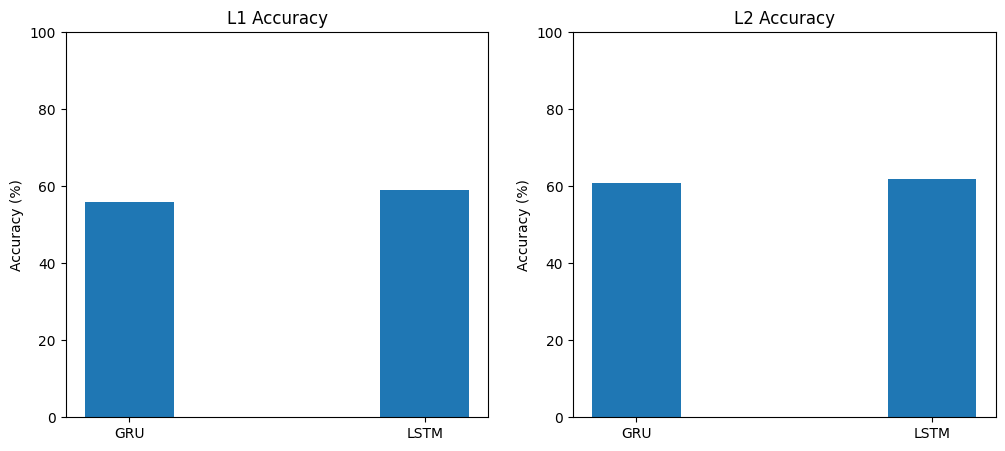

In [ ]:
categories = ['GRU', 'LSTM']
l1_values = [l1_gru_test_accuracy, l1_lstm_test_accuracy]
l2_values = [l2_gru_test_accuracy, l2_lstm_test_accuracy]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(categories, l1_values, width=0.3)
ax1.set_ylabel('Accuracy (%)')
ax1.set_ylim(0, 100)
ax1.set_title('L1 Accuracy')

ax2.bar(categories, l2_values, width=0.3)
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim(0, 100)
ax2.set_title('L2 Accuracy')

plt.show()

As you can see, the LSTM learned to generalize much better than the GRU.

## Inspect models hidden states

Now, I will pass some samples to the models, to see whether they maintain a counting mechanism in order to classify the samples. I will do it by plotting the hidden state vector of the models in each time step ($h_t$ vector of the GRU, and $c_t$ vector of the LSTM).
Formally, given a GRU model with hidden state dimension $d$, and a sequence with length $n$, we have $n+1$ hidden state vectors $h_0,\:h_1,\: h_2, ... , \:h_n\in ℝ^d$ representing the hidden state at each time step $t$. I will plot a curve for each vector $u_1,\:u_2, ... , \:u_d\in ℝ^{n+1}\:$ where
$u_i = (h_0[i], h_1[i], h_2[i],...,h_n[i])\:$
in order to see the progress of each cell in the hidden state vector, and how it is updating during the pass of the sample in the network.

For a LSTM model with cell state dimension $d$, and a sequence with length $n$, we have $n+1$ cell state vectors $c_0,\:c_1,\: c_2, ... , \:c_n\in ℝ^d$ representing the cell state at each time step $t$. A curve will be plotted for each vector $u_1,\:u_2, ... , \:u_d\in ℝ^{n+1}\:$ where
$u_i = (c_0[i], c_1[i], c_2[i],...,c_n[i])\:$.


In [ ]:
def plot_predicted_class(ax, y):
    """
    given model logits (y), plot the predicted class and probaiility on the ax.
    """
    y = y.squeeze(0)
    probabilities = torch.softmax(y, dim=0)
    pred_class = torch.argmax(probabilities).item()
    pred_prob = probabilities[pred_class].item()
    text = f"Predicted Class: {pred_class}\nProbability: {pred_prob:.2f}"
    ax.text(0.05, 0.95, text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

In [ ]:
def plot_gru_hidden_states(model: TemplateRNN, lang: str, sample: str, charIdx: CharIndex):
    """
    plot the progress of the hidden states of the GRU model.
    """
    figure, ax = plt.subplots(figsize=(10, 5))
    sample_tensor = torch.tensor(charIdx.sample_indices(sample)).unsqueeze(0)
    lengths = [len(sample)]
    model.eval()
    with torch.no_grad():
        y, unpacked_out, _ = model(sample_tensor, lengths)
        unpacked_out = unpacked_out.squeeze(0)
        u_0 = torch.zeros(unpacked_out.shape[1])  # hidden state at time step 0.
        unpacked_out = torch.cat([u_0.unsqueeze(0), unpacked_out], dim=0)
        for i in range(model.hidden_state_size):
            u_i = unpacked_out[:, i].numpy()
            ax.plot(u_i, label=f'cell {i}')

    plot_predicted_class(ax, y)
    plt.title(f"{lang} GRU")
    ax.legend(fontsize=10, framealpha=0.7)
    plt.show()

In [ ]:
def plot_lstm_cell_states(model: TemplateRNN, lang: str, sample: str, charIdx: CharIndex):
    """
    plot the progress of the cell states of the LSTM model.
    """
    figure, ax = plt.subplots(figsize=(10, 5))
    sample_tensor = torch.tensor(charIdx.sample_indices(sample)).unsqueeze(0)
    lengths = [len(sample)]
    model.eval()
    with torch.no_grad():
        y, unpacked_out, _ = model(sample_tensor, lengths)
        unpacked_out = unpacked_out.squeeze(0)
        # print("unpacked_out: ", unpacked_out.shape)
        # print("unpacked_out: ", unpacked_out)

        all_cell_states, all_hidden_states = model.get_lstm_cell_states(sample_tensor)
        # print("all_hidden_states: ", all_hidden_states.shape)
        # print("all_hidden_states: ", all_hidden_states)

        if not torch.allclose(all_hidden_states, unpacked_out, atol=1e-03, rtol=1e-05):
          print("Error: hidden states are not equal")
          return

        u_0 = torch.zeros(all_cell_states.shape[1])  # cell state at time step 0.
        all_cell_states = torch.cat([u_0.unsqueeze(0), all_cell_states], dim=0)
        for i in range(model.hidden_state_size):
            u_i = all_cell_states[:, i].numpy()
            ax.plot(u_i, label=f'cell {i}')

    plot_predicted_class(ax, y)
    plt.title(f"{lang} LSTM")
    ax.legend(fontsize=10, framealpha=0.7)
    plt.show()

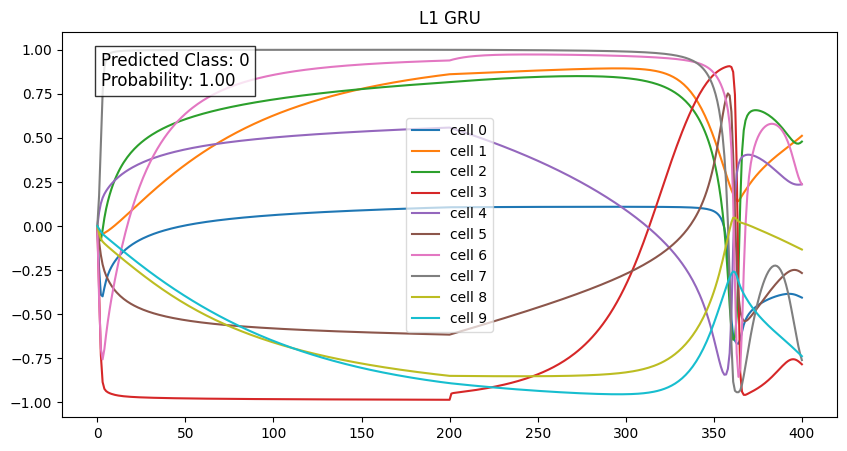

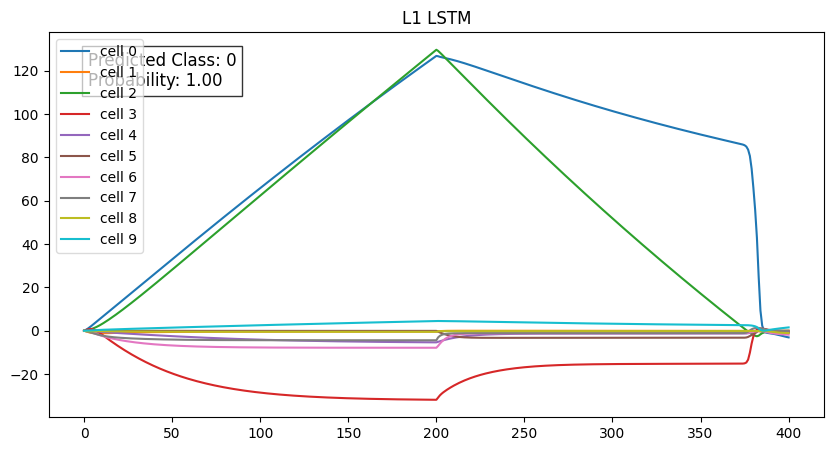

In [ ]:
sample = 'a' * 200 + 'b' * 200
plot_gru_hidden_states(model=l1_gru_model, lang="L1", sample=sample, charIdx=CharIndex())
plot_lstm_cell_states(model=l1_lstm_model, lang="L1", sample=sample, charIdx=CharIndex())

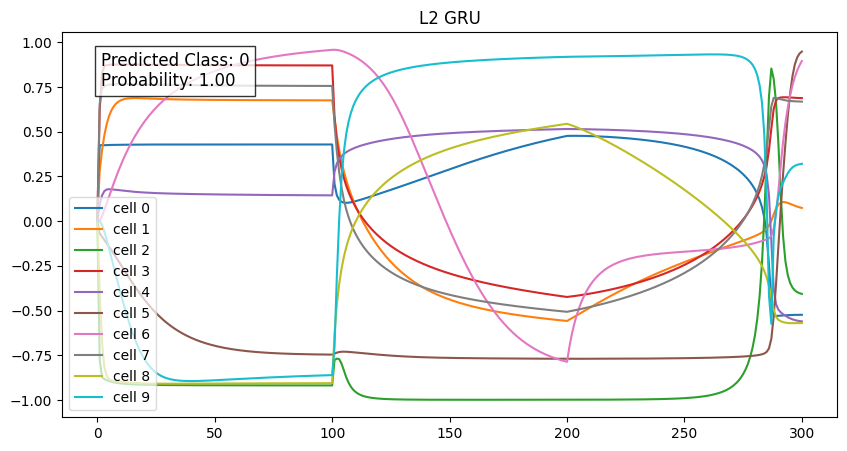

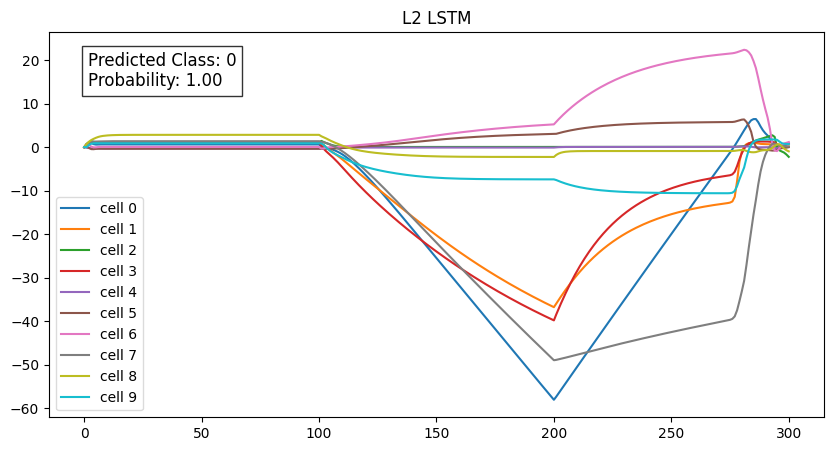

In [ ]:
sample = 'a' * 100 + 'b' * 100 + 'c' * 100
plot_gru_hidden_states(model=l2_gru_model, lang="L2", sample=sample, charIdx=CharIndex())
plot_lstm_cell_states(model=l2_lstm_model, lang="L2", sample=sample, charIdx=CharIndex())

The above plots show the activations of $10$-$d$ LSTM and GRU trained to recognize $L_1,L_2$. It is clear that the LSTM learned to dedicate specific dimensions for counting, in contrast to the GRU.

Areas for improvement:

**Generalization ranges**: Consider adding code and visualizations to explore the generalization capabilities of the models.

**Hyperparameter tuning**: Explore different hyperparameters for the models using `Optuna` to potentially improve performance.


# Summary

In contrast to GRU, LSTM manages to learn the essence of the counting based solution using back-propagation. i.e. I showed empirically that the LSTM can easily perform counting and generalize to much higher range than seen in training, while the GRU cannot. This makes the LSTM a variant of a k-counter machine, while the GRU remains finite-state. These suggests, according to the paper, that there is a class of formal languages that can be recognized by LSTMs but not by GRUs. I demonstrated that for $L_1,L_2$.

# Comparison with an Existing Project

There is one existing project that implementing the paper. You can find it in https://github.com/hakunanatasha/counting_NN by hakunanatasha (from now on haku) and it is a bad one, for this main reason:

**Wrong** Data Generation for both positive and negative samples.

**Explanation:** In his implementation, haku consider only $a^Nb^N$ as
a positive sample for $L_1$, and hence genereted ```n_samples``` copies of the same sample as his training set, which is completely wrong, becasue the model needs to train on the whole $[1,N]$ range, as mentioned in the paper. Regarding to the negative samples, haku consider also different permutations of $a$ and $b$ as negative samples for $L_1$ (e.g. aaabbaaabb), while negative samples must be $a^ib^j$ where $i\neq j$, because the model is training to count, not to capture different order of a's and b's in a sample (the universe is $\:U = \{a^ib^j \:|\:  i,j \in ℕ\}$).